# Mapping Urban Temperatures

This Jupyter Notebook demonstrates how to map heatwave impact over cities based on the [Land Surface Temperature](https://docs.planet.com/data/planetary-variables/land-surface-temperature/) product using the [Processing API](https://docs.sentinel-hub.com/api/latest/api/process/).

In this example, the number of days with an anomaly > 10&deg;C is calculated from the archive of Land Surface Temperature 100m: for the purpose of this demonstration, anomaly is considered as the difference between the LST and the climatology defined by the period requested (note that the period and the anomaly threshold can be changed in the script).

In [3]:
import json
import folium
import numpy as np

import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import getpass

from sentinelhub import (
    SHConfig,
    Geometry,
    CRS,
    DataCollection,
    MimeType,
    SentinelHubRequest,
)

/Users/yoannmalbeteau/miniconda3/envs/sentinelhub_notebook/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Credentials

Process API requires Sentinel Hub account. Please check configuration instructions about how to set up your Sentinel Hub credentials in
the [readme](https://github.com/planetlabs/notebooks/tree/master?tab=readme-ov-file#sentinel-hub-python-sdk)

In [3]:
config = SHConfig()

if not config.sh_client_id or not config.sh_client_secret:
    print("No credentials found, please provide the OAuth client ID and secret.")
    config.sh_client_id = getpass.getpass("sh_client_id: ")
    config.sh_client_secret = getpass.getpass("sh_client_secret: ")
    config.save()
    print(f"Credentials saved to {SHConfig.get_config_location()}")
else:
    print(f"Using credentials stored here: {SHConfig.get_config_location()}")

Connected to Sentinel Hub


### Set collection ID

The 100m [Land Surface Temperature](https://docs.sentinel-hub.com/api/latest/data/planetary-variables/land-surface-temp/) is available as subscriptions through Sentinel Hub's [TPDI](https://docs.sentinel-hub.com/api/latest/api/data-import/) service. Once the area of interest and variables are subscribed to, the data are then automatically imported into Sentinel Hub and available by specifying the Collection ID. 

In this example, we will use the collection IDs available from [Planet's Sandbox Data page for Land Surface Temperature](https://docs.planet.com/data/planetary-variables/land-surface-temperature/sandbox/). 

A collection ID will allow you to retrieve the data from the collection, just as you would with a standard dataset (e.g. Sentinel-2). For more information on how to call a collection ID in a request with Python, you can refer to the `sentinelhub-py` [documentation](https://sentinelhub-py.readthedocs.io/en/latest/examples/byoc_request.html#Retrieve-data-from-collection).

<div style="width: 75%; padding: 15px; border: 2px solid #007980; border-radius: 5px; background-color: transparent; margin-left: 0;">
  <div style="display: flex; justify-content: space-between; align-items: center;">
    <div style="display: flex; align-items: center; flex: 0 0 50%; padding-right: 20px;">
      <svg style="margin-right: 10px; fill: #007980; width: 64px; height: 64px;" viewBox="0 0 24 24">
        <path d="M11,9H13V7H11M12,20C7.59,20 4,16.41 4,12C4,7.59 7.59,4 12,4C16.41,4 20,7.59 20, 12C20,16.41 16.41,20 12,20M12,2A10,10 0 0,0 2,12A10,10 0 0,0 12,22A10,10 0 0,0 22,12A10, 10 0 0,0 12,2M11,17H13V11H11V17Z"></path>
      </svg>
      <p style="font-size: 16px; margin: 0; line-height: 1.5;">
        This notebook makes use of <a href="https://docs.planet.com/data/planet-sandbox-data/" target="_blank">Planet Sandbox Data</a>. You need a Planet account in order to access this data. If you don't already have an account, you can <a href="https://insights.planet.com/sign-up/" target="_blank">create a free 30 day trial</a>.
      </p>
    </div>
    <div style="flex: 0 0 50%; display: flex; justify-content: center; align-items: center;">
      <a href="https://insights.planet.com/sign-up/" target="_blank" style="
        display: inline-block;
        padding: 10px 20px;
        font-size: 16px;
        font-weight: bold;
        color: #fff;
        background-color: #007980;
        border-radius: 5px;
        text-decoration: none;
        white-space: nowrap;
        transition: background-color 0.3s ease;
        margin: 0 auto;
      " onmouseover="this.style.backgroundColor='#005960'" onmouseout="this.style.backgroundColor='#007980'">
        Start Free Trial
      </a>
    </div>
  </div>
</div>


In [4]:
collection_id= "8d977093-cf9e-4351-8159-90f2522c29c1"

data_collection = DataCollection.define_byoc(collection_id)

### Define an area of interest

Now we define an area of interest: The city of Bordeaux in France.

In this example, the area of interest is defined as a GeoJSON file in EPSG:4326. We will read the geoJSON and plot the area of interest on an interactive map.

You can also explore the area of interest in Sentinel Hub's [EO Browser](https://sentinelshare.page.link/EeYH). 

In [7]:
# Read a geojson containing a polygon representing the city of Bordeaux, France
with open("bordeaux.geojson") as file:
    bordeaux_json = json.load(file)

# Load GeoJSON into a shapely polygon
bordeaux_polgyon = Polygon(bordeaux_json["features"][0]["geometry"]["coordinates"][0][0])

# Convert shapely polygon to a Sentinel Hub geometry
bordeaux_aoi = Geometry(bordeaux_polgyon, crs=CRS(4326))

In [8]:
# Plot the parcel on an interactive map
m = folium.Map(
    location=[
        bordeaux_polgyon.centroid.coords.xy[1][0],
        bordeaux_polgyon.centroid.coords.xy[0][0],
    ],
    zoom_start=11,
    tiles="OpenStreetMap",
)
geo_j = folium.GeoJson(data=bordeaux_polgyon, style_function=lambda x: {"fillColor": "blue"})
geo_j.add_to(m)
m

### Compute the number of days with high anomaly positive

In the following step, we will use Sentinel Hub's Processing API to retrieve the number of days with anomaly > 10&deg;C at 13.30 over the city of Bordeaux between the month of June and September.

In [11]:
sensingTime = "1330" # Solar local time
LST_threshold = 10 # temperature threshold in degrees Celsius/Kelvin
min_month = 7 # July
max_month = 9 # September

In [12]:
count_evalscript = f"""
//VERSION=3
const sensingTime = {sensingTime}

const NODATA = NaN;
const band = "LST";

function setup() {{
    return {{
        input: [band, "dataMask"],
        output: {{ id: "anomalyCount", bands: 1, sampleType: "INT16" }},
        mosaicking: "TILE",
    }};
}}

function sortDatesDescending(d1, d2) {{
    const date1 = new Date(d1.date);
    const date2 = new Date(d2.date);
    return date2 - date1;
}}

function preProcessScenes(collections) {{
    let scenes = collections.scenes.tiles.filter(function (tile) {{
        let date = new Date(tile.date);
        let month = date.getMonth();
        return tile.dataPath.includes("T" + sensingTime) && month >= {min_month} && month <= {max_month};
    }});
    scenes = scenes.sort(sortDatesDescending);
    collections.scenes.tiles = scenes;
    return collections;
}}

function calculateAnomaly(data) {{
    let grouped = {{}};
    for (let i = 0; i < data.length; i++) {{
        let date = new Date(data[i].date);
        let doy = Math.floor((date - new Date(date.getFullYear(), 0, 0)) / 1000 / 60 / 60 / 24);
        if (!grouped[doy]) {{
            grouped[doy] = [];
        }}
        if (data[i].dataMask) {{
            grouped[doy].push(data[i].LST/100);
        }}
    }}

    let averages = {{}};
    for (let doy in grouped) {{
        let sum = grouped[doy].reduce((a, b) => a + b, 0);
        averages[doy] = sum / grouped[doy].length;
    }}

    let anomalies = data.map(item => {{
        let date = new Date(item.date);
        let doy = Math.floor((date - new Date(date.getFullYear(), 0, 0)) / 1000 / 60 / 60 / 24);

        anomaly=(item.LST/100) - averages[doy];
    
        return {{
            anomaly_LST: anomaly,
            climatology: averages[doy],
        }};
    }});

    let anomalyCount = 0;
    for (let i = 0; i < anomalies.length; i++) {{
          if (anomalies[i].anomaly_LST > {LST_threshold}) {{
              anomalyCount++;
      }}
    }}
    return anomalyCount;
}}

function evaluatePixel(samples) {{
    let anomalyCount = calculateAnomaly(samples);
    return [anomalyCount];
}}
"""

### Prepare the request

We build the request according to the [API Reference](https://docs.sentinel-hub.com/api/latest/api/process/), using the `SentinelHubRequest` class from the `sentinelhub-py` [Python package](https://sentinelhub-py.readthedocs.io/en/latest/index.html). Each Process API request also needs an [evalscript](https://docs.sentinel-hub.com/api/latest/evalscript/v3/). 

This request is going to take <b>approximately 4 minutes to complete</b>. Land Surface Temperature data for hundreds of days across several years is being requested, aggregated, and analyzed in the cloud before returning a single raster that represents the climate anomaly.

In [13]:
request_anomaly_count = SentinelHubRequest(
    evalscript=count_evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            DataCollection.define_byoc(collection_id),
            time_interval=(f"2017-07-01", f"2022-12-31"),
        ),
    ],
    responses=[SentinelHubRequest.output_response("anomalyCount", MimeType.TIFF)],
    geometry=bordeaux_aoi,
    resolution=(0.001, 0.001),
    data_folder=".",
    config=config,
)

# Run the request
anomaly_count_data = request_anomaly_count.get_data()

### Plot results

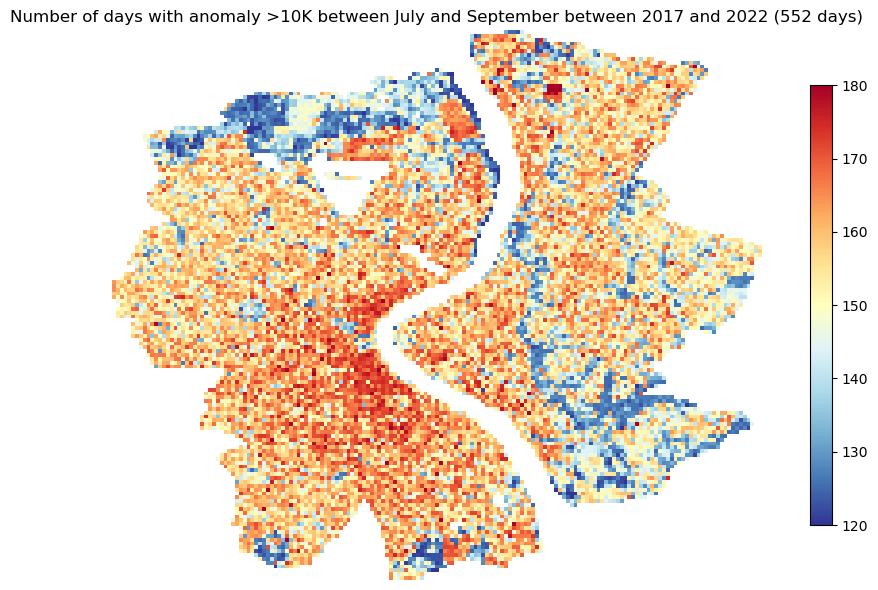

In [18]:
masked_data = np.ma.masked_where(anomaly_count_data[0] == 0, anomaly_count_data[0])

fig, ax = plt.subplots(figsize=(10, 6))
plt.imshow(masked_data, cmap="RdYlBu_r", vmin=120, vmax=180)
plt.title(f"Number of days with anomaly >{LST_threshold}K between July and September between 2017 and 2022 (552 days)")
plt.tight_layout
plt.colorbar(orientation='vertical', shrink=0.8)

ax.axis('off')
ax.set_frame_on(False)
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()